Restarted aspire (Python 3.8.18)

In [12]:
import aspire
import numpy as np
import pandas as pd
from aspire.operators import RadialCTFFilter
from aspire.source.simulation import Simulation
from aspire.volume import LegacyVolume, Volume
from utils import volsCovarEigenvec
import time
from covar_estimation import im_stack_backward
import torch
# Specify parameters
img_size = 101  # image size in square
num_imgs = 2000  # number of images
dtype = np.float32

rank = 4
c = rank + 1
vols = LegacyVolume(
    L=img_size,
    C=c,
    dtype=dtype,
).generate()
vols -= np.mean(vols,axis=0)
sim = Simulation(
    #unique_filters=[RadialCTFFilter(defocus=d) for d in np.linspace(1.5e4, 2.5e4, 7)],
    n=num_imgs,
    vols=vols,
    dtype=dtype,
    amplitudes=1,
    offsets = 0
)

vectorsGD = torch.tensor(volsCovarEigenvec(vols),requires_grad = False)


2024-04-12 17:07:16,025 INFO [aspire.source.image] Creating Simulation with 2000 images.


In [65]:
%load_ext autoreload
%autoreload 2

from covar_sgd import CovarDataset,Covar,CovarTrainer
cds = CovarDataset(sim,vectorsGD = vectorsGD)
covar = Covar(resolution=img_size,rank=rank,vectors=vectorsGD.reshape((rank,img_size,img_size,img_size))/cds.im_norm_factor)
batch_size = 1
learning_rate = 1e-4 
momentum = 0.9
reg = 1e-5
gamma_lr = 0.8
gamma_reg = 1
kwargs_dict = {'max_epochs' : 10, 'lr' : learning_rate,'momentum' : momentum,'optim_type' : 'SGD','reg' : reg,'gamma_lr': gamma_lr,'gamma_reg' : gamma_reg}
#kwargs_dict = {'max_epochs' : 10, 'lr' : 1e-10,'momentum' : momentum,'optim_type' : 'Adam','reg' : reg,'gamma_lr': gamma_lr,'gamma_reg' : gamma_reg}
device = torch.device('cuda:0')
dataloader = torch.utils.data.DataLoader(cds,batch_size = batch_size,shuffle = False)#,collate_fn=dataset_collate)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
torch.manual_seed(0)
from covar_distributed import trainParallel

trainParallel(covar,cds,num_gpus = 2,batch_size = batch_size,**kwargs_dict)



Batch size is not a multiple of number of GPUs used, increasing batch size to 2


Epoch 0 , cost value : 1.44e+00,  cosine sim : 0.93, frobenium norm error : 6.62e-01:   6%|▌         | 62/1000 [00:02<00:29, 32.12it/s]

(61, tensor(1.5919e+08, device='cuda:1', grad_fn=<MeanBackward1>), tensor(1.1476, device='cuda:1'), tensor(1833.8568, device='cuda:1'), tensor(114.8788, device='cuda:1'), tensor(49.8492, device='cuda:1'), tensor(70.4866, device='cuda:1'))
tensor([[-2.6555, -2.6046, -2.5537,  ...,  2.5537,  2.6046,  2.6555],
        [ 2.8243,  2.8460,  2.8676,  ..., -2.8676, -2.8460, -2.8243],
        [-0.5789, -0.6074, -0.6359,  ...,  0.6359,  0.6074,  0.5789]],
       device='cuda:1')


ProcessRaisedException: 

-- Process 1 terminated with the following error:
Traceback (most recent call last):
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/torch/multiprocessing/spawn.py", line 68, in _wrap
    fn(i, *args)
  File "/scratch/home/roaiyadgar/thesis/covar_distributed.py", line 27, in ddp_train
    trainer.train(**kwargs)
  File "/scratch/home/roaiyadgar/thesis/covar_sgd.py", line 136, in train
    self.run_epoch(epoch)
  File "/scratch/home/roaiyadgar/thesis/covar_sgd.py", line 109, in run_epoch
    cost_val,vectors = self.run_batch(images,self.nufft_plans[:num_ims])
  File "/scratch/home/roaiyadgar/thesis/covar_sgd.py", line 81, in run_batch
    cost_val,vectors = self.covar.forward(images,nufft_plans,self.reg,self.counter)
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/torch/nn/parallel/distributed.py", line 1523, in forward
    else self._run_ddp_forward(*inputs, **kwargs)
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/torch/nn/parallel/distributed.py", line 1359, in _run_ddp_forward
    return self.module(*inputs, **kwargs)  # type: ignore[index]
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/roaiyadgar/miniconda3/envs/aspire/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/scratch/home/roaiyadgar/thesis/covar_sgd.py", line 192, in forward
    return self.cost(images,nufft_plans,reg,ind),self.vectors
  File "/scratch/home/roaiyadgar/thesis/covar_sgd.py", line 188, in cost
    return cost(self.vectors,images,nufft_plans,reg,ind)
  File "/scratch/home/roaiyadgar/thesis/covar_sgd.py", line 224, in cost
    ghgh
NameError: name 'ghgh' is not defined


In [56]:
torch.manual_seed(0)
trainer = CovarTrainer(covar,dataloader,device)
trainer.train(**kwargs_dict)

Epoch 0 , cost value : 7.70e-01,  cosine sim : 0.82, frobenium norm error : 7.73e-01: 100%|██████████| 2000/2000 [00:48<00:00, 41.03it/s]
Epoch 1 , cost value : 3.11e-01,  cosine sim : 0.83, frobenium norm error : 7.27e-01:   5%|▍         | 99/2000 [00:02<00:37, 51.17it/s]

KeyboardInterrupt: 

In [ ]:
%load_ext autoreload
%autoreload 2
from covar_analyzer import CovarAnalyzer
import torch
c = CovarAnalyzer.load('data/tmp2/results.csv')

#c.plotCosineSim()
#c.plotWeightedCosineSim()
c.plotFroErr()




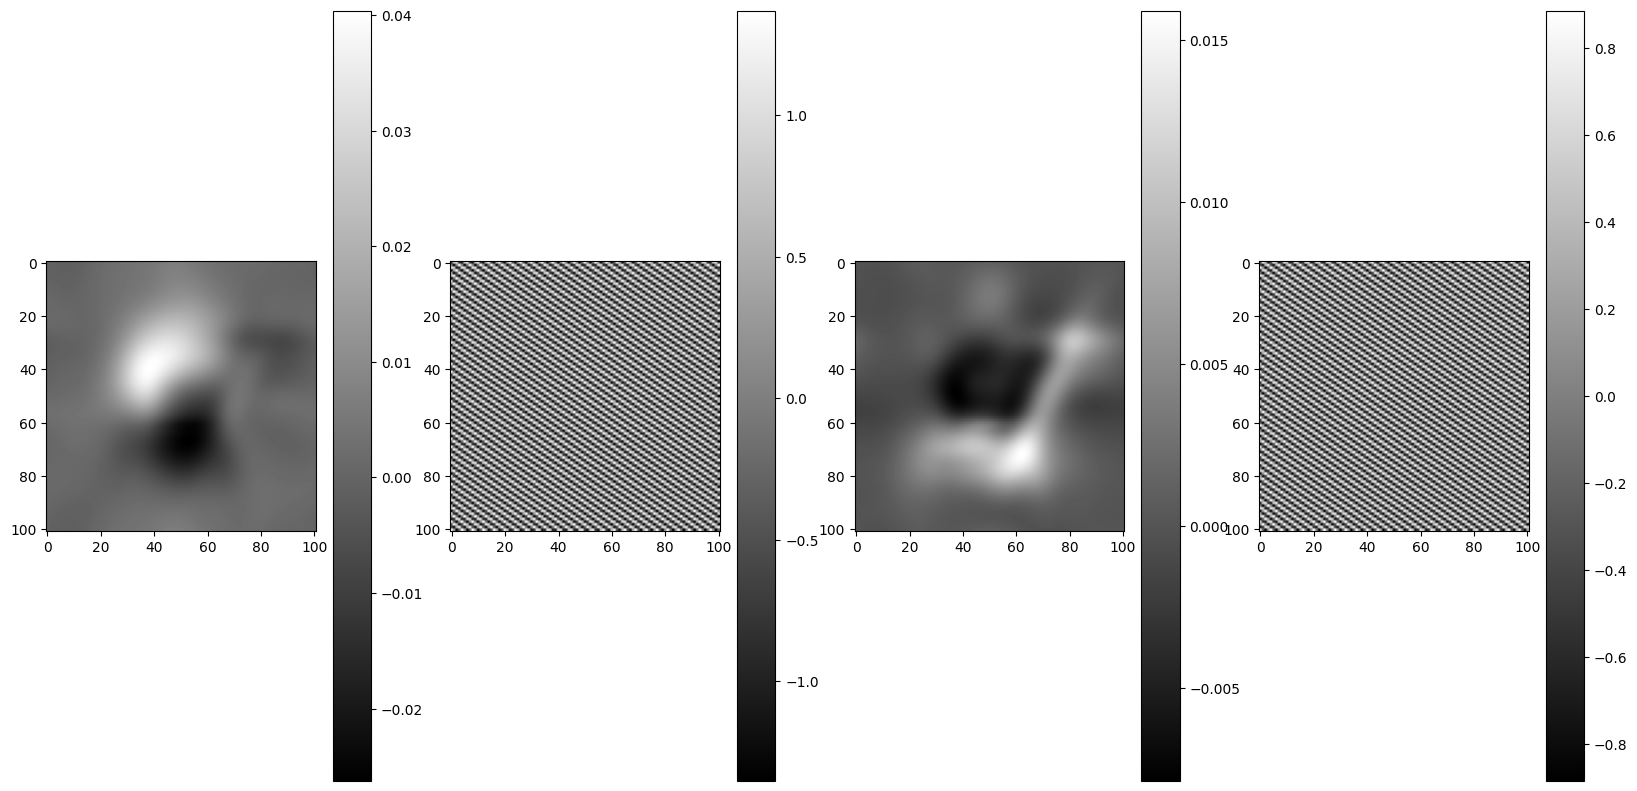

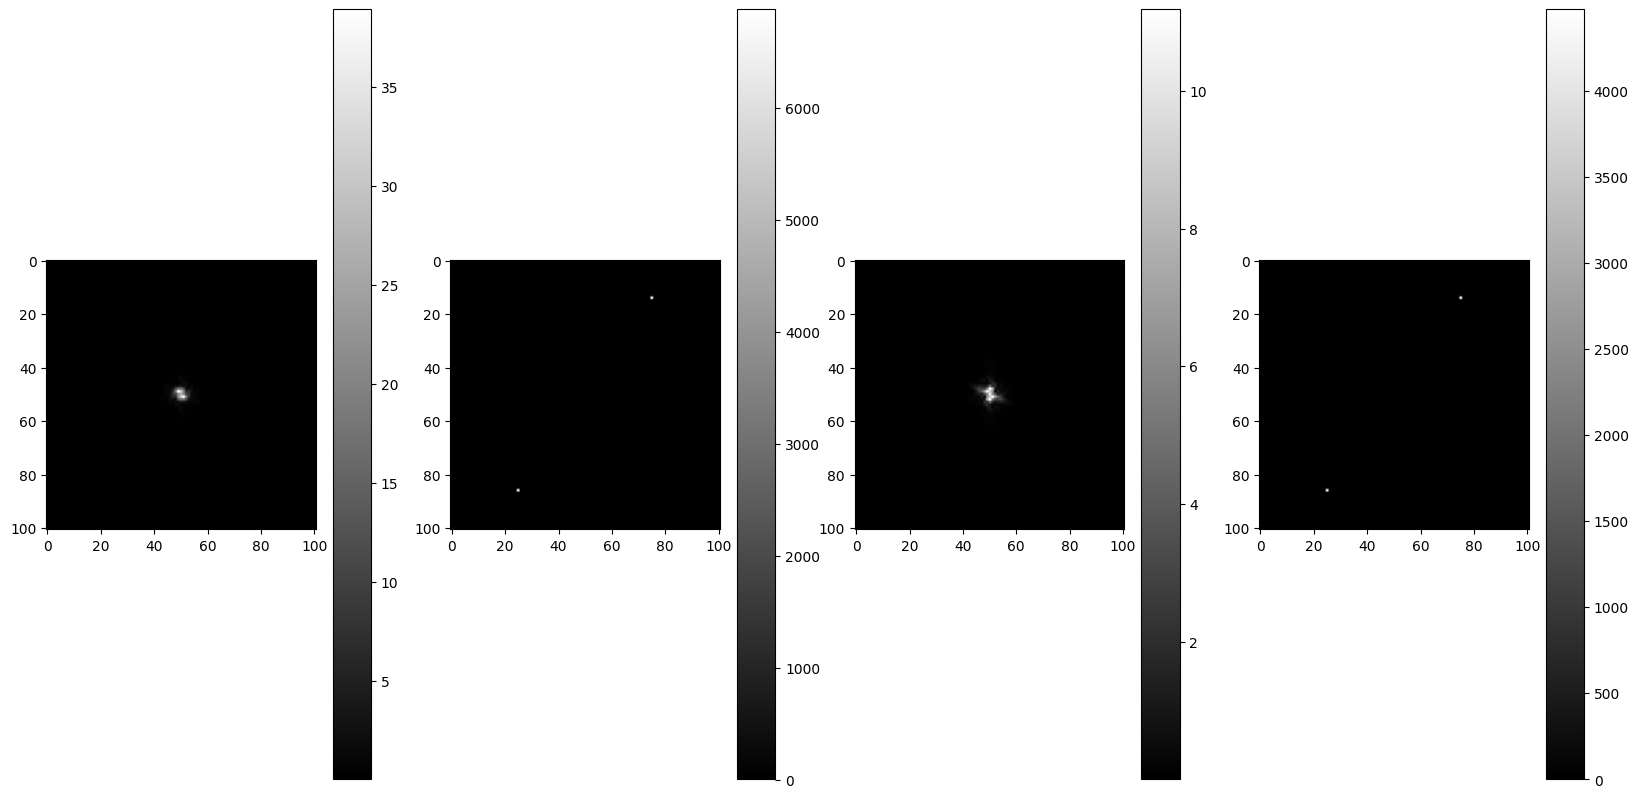

In [67]:
import pickle
from projection_funcs import centered_fft2,vol_forward
x = pickle.load(open('data/pts.bin','rb'))
projs = x['projs'][0].reshape((rank,img_size,img_size))
fft_projs = aspire.image.Image(np.abs(centered_fft2(torch.tensor(projs)).numpy()))
projs = aspire.image.Image(projs)


projs.show()
fft_projs.show()

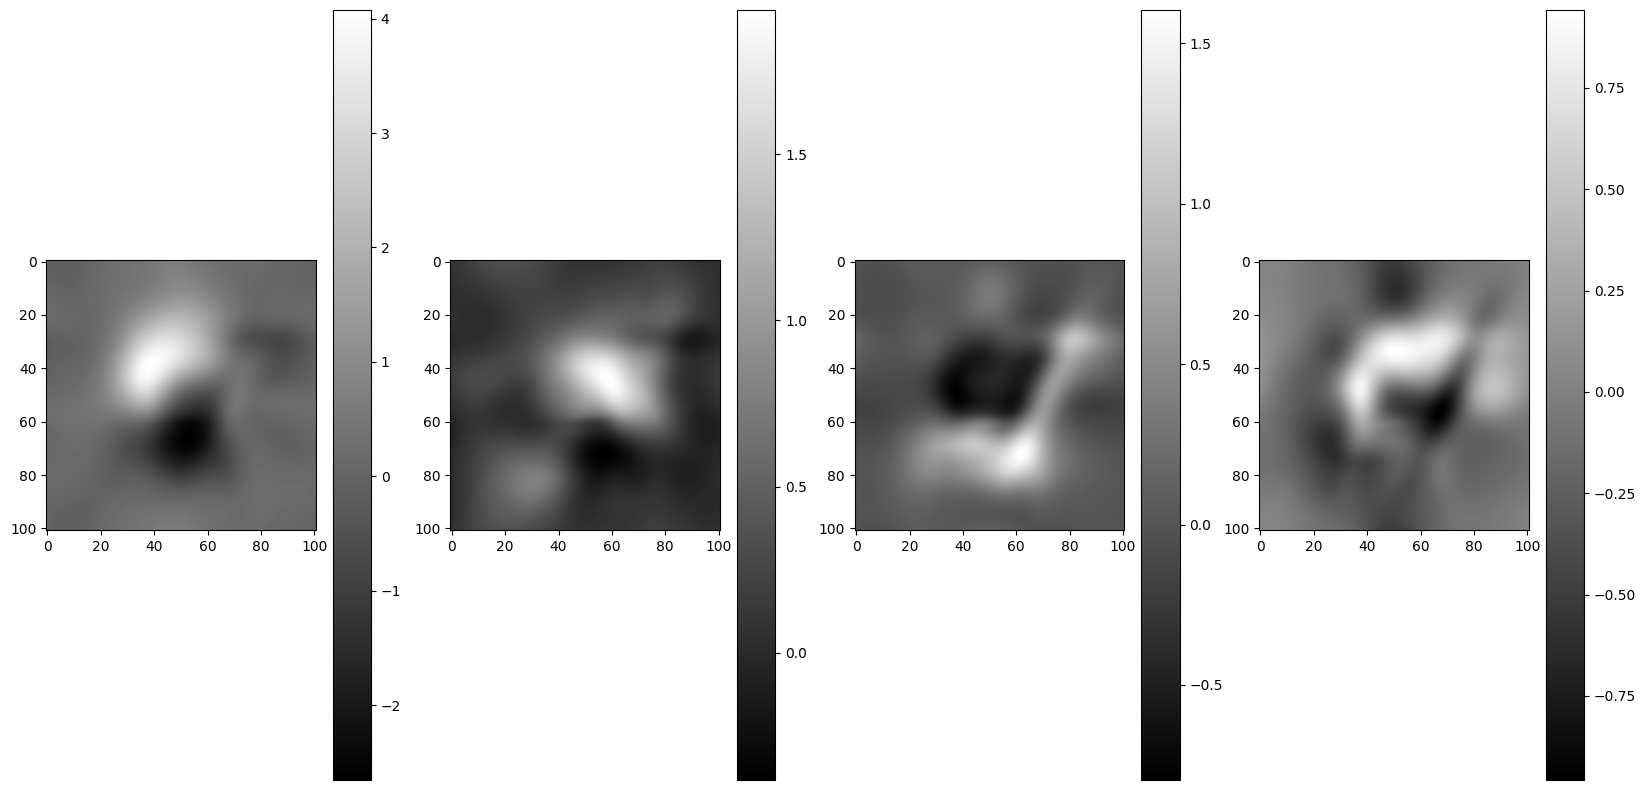

In [68]:
from nufft_plan import NufftPlan
d = torch.device('cuda:1')
plan = NufftPlan((img_size,)*3,batch_size = rank,gpu_device_id = d.index,gpu_method=1,gpu_sort = 0)
plan.setpts(torch.tensor(x['pts']).to(d))
vols = torch.tensor(x['vols']).to(d)
proj_vols = vol_forward(vols,plan)
p = aspire.image.Image(proj_vols.cpu().numpy())
p.show()

In [31]:
b = fft_projs.asnumpy()[1].reshape(1,-1)
a = np.argmax(fft_projs.asnumpy()[1])
b[0,a]
x['pts'][:,a]
x['pts']

array([[ 2.830876 ,  2.8036406,  2.776405 , ..., -2.776405 , -2.8036406,
        -2.830876 ],
       [-1.8112369, -1.7555761, -1.6999154, ...,  1.6999152,  1.7555764,
         1.8112366],
       [-2.8382797, -2.8327878, -2.8272958, ...,  2.8272955,  2.8327878,
         2.83828  ]], dtype=float32)